# Project SG2212

Development of a Python code to solve the two-dimensional Navier-Stokes equations on a rectangular domain.

Code worked on by Garrett Kunkler, Michaela Jankulicova, and Sebastian Lis

Import some relevant libraries:

In [599]:
%matplotlib inline
# possible options: notebook, inline or widget #TODO: check whether this works properly
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation
import math 
import scipy.sparse as sp
import scipy.linalg as scl
from scipy.sparse.linalg import splu
params = {'legend.fontsize': 12,
          'legend.loc':'best',
          'figure.figsize': (8,5),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize':12,
          'ytick.labelsize':12,
          'grid.alpha':0.6}
pylab.rcParams.update(params)

Some useful functions:

In [600]:
def avg(A,axis=0):
    """
    Averaging function to go from cell centres (pressure nodes)
    to cell corners (velocity nodes) and vice versa.
    avg acts on index idim; default is idim=1.
    """
    # 
    if (axis==0):
        B = (A[:-1,] + A[1:,])/2. #Gets averages between values in y direction (rows) #TODO 1
    elif (axis==1):
        B = (A[:,:-1] + A[:,1:])/2. #Gets averages between values in x direction (cols) #TODO 2
    else:
        raise ValueError('Wrong value for axis')
    return B           

def DD(n,h):
    """
    One-dimensional finite-difference derivative matrix 
    of size n times n for second derivative:
    h^2 * f''(x_j) = -f(x_j-1) + 2*f(x_j) - f(x_j+1)

    Homogeneous Neumann boundary conditions on the boundaries 
    are imposed, i.e.
    f(x_0) = f(x_1) 
    if the wall lies between x_0 and x_1. This gives then
    h^2 * f''(x_j) = + f(x_0) - 2*f(x_1) + f(x_2)
                   = + f(x_1) - 2*f(x_1) + f(x_2)
                   =              f(x_1) + f(x_2)

    For n=5 and h=1 the following result is obtained:
 
    A =
        -1     1     0     0     0
         1    -2     1     0     0
         0     1    -2     1     0
         0     0     1    -2     1
         0     0     0     1    -1
    """
    center_diag = np.zeros(n)
    center_diag[0] = 1
    center_diag[-1] = 1
    center_diag = center_diag -2*np.ones(n)
    data = [np.ones(n), center_diag, np.ones(n)] #Defines the values in each specified diagonal #TODO 3
    diags = np.array([-1,0,1]) #Determines which diagonals are stored in the sparse matrix (one above and one below the main diagonal) #TODO 4
    A = sp.spdiags(data, diags, n, n) / h**2
    return A
    
# DD(5,1).toarray()

Homemade version of Matlab tic and toc functions

In [601]:
def tic():
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [602]:
# Testing above functions:

A = np.array([1,2,3,4,5])
A = np.transpose(A)
A = np.tile(A, (5,1))
print(A)
print(avg(A))
print(avg(A,1))

print(DD(5,1))

[[1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]
 [1 2 3 4 5]]
[[1. 2. 3. 4. 5.]
 [1. 2. 3. 4. 5.]
 [1. 2. 3. 4. 5.]
 [1. 2. 3. 4. 5.]]
[[1.5 2.5 3.5 4.5]
 [1.5 2.5 3.5 4.5]
 [1.5 2.5 3.5 4.5]
 [1.5 2.5 3.5 4.5]
 [1.5 2.5 3.5 4.5]]
<DIAgonal sparse matrix of dtype 'float64'
	with 13 stored elements (3 diagonals) and shape (5, 5)>
  Coords	Values
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (4, 3)	1.0
  (0, 0)	-1.0
  (1, 1)	-2.0
  (2, 2)	-2.0
  (3, 3)	-2.0
  (4, 4)	-1.0
  (0, 1)	1.0
  (1, 2)	1.0
  (2, 3)	1.0
  (3, 4)	1.0


Simulation parameters:

In [ ]:
Pr = 0.71
Re = 25 #TODO 5
# Ri = 0. 
dt = 0.001 #TODO 6
Tf = 20
Lx = 1.
Ly = 1.
Nx = 30 #TODO 7
Ny = 30 #TODO 8
namp = 0. # Adds randomness to starting temperature
ig = 200

Discretisation in space and time, and definition of boundary conditions:

In [ ]:
# number of iteratins
Nit = 50000 #TODO 9
# edge coordinates
x = np.linspace(0,Lx, Nx+1) #TODO 10
y = np.linspace(0,Ly, Ny+1) #TODO 11
# grid spacing
hx = Lx/Nx #TODO 12
hy = Ly/Ny #TODO 13

In [605]:
# boundary conditions
Utop = 1.
Ttop = 1.
Tbottom = 0.

uN = x*0 + Utop # u is aligned with the vertical grid edges
uN = uN[:, np.newaxis] # converts it to a column matrix (i varies, j const.)
vN = avg(x)*0 # v is offset from vertical grid edges so use average to get them
vN = vN[:, np.newaxis]

uS = x*0 #TODO 14
uS = uS[:, np.newaxis]
vS = avg(x)*0 #TODO 15
vS = vS[:, np.newaxis]

uW = avg(y)*0 # u is offset from horizontal grid edges
uW = uW[np.newaxis, :] # converts it to a row matrix (i const. j varies)
vW = y*0 # v is aligned with horizontal grid edges #TODO 16
vW = vW[np.newaxis, :] #TODO 17

uE = avg(y)*0
uE = uE[np.newaxis, :]
vE = y*0
vE = vE[np.newaxis, :]

tN = x*0 + Ttop #TODO 18
tS = x*0 + Tbottom #TODO 19

In [606]:
print(x)
print(y)
print(uN)
print(uS)
print(uW)
print(uE)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Pressure correction and pressure Poisson equation:

In [607]:
# Compute system matrices for pressure 
# Laplace operator on cell centres: Fxx + Fyy

# First set homogeneous Neumann condition all around
Lp = np.kron(sp.eye(Ny).toarray(), DD(Nx, hx).toarray()) + np.kron(DD(Ny, hy).toarray(), sp.eye(Nx).toarray()) #pg 18
# Lp = np.kron(....).toarray(),DD(.....).toarray()) + np.kron(.....).toarray(),sp.eye(.....).toarray()) #TODO 20

# Set one Dirichlet value to fix pressure in that point
# Lp[:,0] = 0 #Makes sure that the pressure at (0,0) doesn't change #TODO 21
Lp[0,:] = 0 #TODO 22
Lp[0,0] = 1 # Allows Lp to be non-singular and have a non-zero determinant. Actual value doesn't matter #TODO 23

print(Lp)

Lp_lu, Lp_piv = scl.lu_factor(Lp)
Lps = sp.csc_matrix(Lp)
Lps_lu = splu(Lps)

[[   1.    0.    0. ...    0.    0.    0.]
 [ 100. -300.  100. ...    0.    0.    0.]
 [   0.  100. -300. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... -300.  100.    0.]
 [   0.    0.    0. ...  100. -300.  100.]
 [   0.    0.    0. ...    0.  100. -200.]]


Initial conditions:

In [608]:
U = np.zeros((Nx-1,Ny))
V = np.zeros((Nx,Ny-1))

T = np.zeros((Nx,Ny)) + namp*(np.random.rand(Nx,Ny)-0.5) #TODO 24

Main time-integration loop. Write output file "cavity.mp4" if 

In [609]:
if (ig>0):
    metadata = dict(title='Lid-driven cavity', artist='SG2212')
    writer = matplotlib.animation.FFMpegWriter(fps=15, metadata=metadata)
    matplotlib.use("Agg")
    fig=plt.figure()
    writer.setup(fig,"cavity.mp4",dpi=200)

# progress bar
print('[         |         |         |         |         ]')
tic()
for k in range(Nit):
    # print("Iteration k=%i time=%.2e" % (k,k*dt))

    # include all boundary points for u and v (linear extrapolation
    # for ghost cells) into extended array (Ue,Ve)
    Ue = np.vstack((uW, U, uE)) # first add W and E boundary conditions
    Ue = np.hstack((2*uS-Ue[:,0,np.newaxis], Ue, 2*uN-Ue[:,-1,np.newaxis]))

    Ve = np.hstack((vS, V, vN)) #TODO 25
    Ve = np.vstack(((2*vW-Ve[np.newaxis,0,:], Ve, 2*vE-Ve[np.newaxis,-1,:])))

    # averaged (Ua,Va) of u and v on corners
    Ua = avg(Ue, axis=1) #TODO 26
    Va = avg(Ve)  #TODO 27

    # print(np.max(Ua*Va))

    #  construct individual parts of nonlinear terms
    dUVdx = np.diff(Ua*Va, axis=0)/hx #TODO 28
    dUVdy = np.diff(Ua*Va, axis=1)/hy #TODO 29
    Ub    = avg(Ue[:,1:-1],0) # Average non-extrapolated points?  
    Vb    = avg(Ve[1:-1,:],1) #TODO 30
    dU2dx = np.diff(Ub*Ub, axis=0)/hx #TODO 31
    dV2dy = np.diff(Vb*Vb, axis=1)/hy #TODO 32

    # treat viscosity explicitly
    viscu = np.diff(Ue[:,1:-1],axis=0,n=2)/hx**2 + np.diff(Ue[1:-1,:],axis=1,n=2)/hy**2 #eq 35 #TODO 33
    viscv = np.diff(Ve[:,1:-1],axis=0,n=2)/hx**2 + np.diff(Ve[1:-1,:],axis=1,n=2)/hy**2 #TODO 34

    # Assume forcing terms are zero?

    # print(f'max dU2dx: {np.max(np.abs(dU2dx))}')
    # print(f'max dUVdy: {np.max(np.abs(dUVdy))}')
    # print(f'max viscu: {np.max(np.abs(viscu))}')

    # compose final nonlinear term + explicit viscous terms
    U = U + dt*(-dU2dx - dUVdy[1:-1,:] + 1/Re*viscu) #TODO 35
    V = V + dt*(-dUVdx[:,1:-1] - dV2dy + 1/Re*viscv) #TODO 36

    # pressure correction, Dirichlet P=0 at (1,1)
    rhs = (np.diff(np.vstack((uW,U,uE)), axis=0)/hx + np.diff(np.hstack((vS, V, vN)),axis=1)/hy)/dt #TODO 37
    rhs = np.reshape(rhs.T,(Nx*Ny,1)) #TODO 38
    rhs[0] = 0

    # different ways of solving the pressure-Poisson equation:
    P = Lps_lu.solve(rhs) #TODO 39

    P = np.reshape(P.T, (Ny, Nx)).T #TODO 40

    # apply pressure correction
    U = U - dt*np.diff(P, axis=0)/hx #TODO 41
    V = V - dt*np.diff(P, axis=1)/hy #TODO 42

    # Temperature equation (ignored?)
    # .... #TODO 43

    # do postprocessing to file
    if (ig>0 and np.floor(k/ig)==k/ig):
        plt.clf()
        plt.contourf(avg(x),avg(y),T.T,levels=np.arange(0,1.05,0.05))
        plt.gca().set_aspect(1.)
        plt.colorbar()
        plt.title(f'Temperature at t={k*dt:.2f}')
        writer.grab_frame()

    # update progress bar
    if np.floor(51*k/Nit)>np.floor(51*(k-1)/Nit): 
        print('.',end='')

# finalise progress bar
print(' done. Iterations k=%i time=%.2f' % (k,k*dt))
toc()

if (ig>0):
    writer.finish()

[         |         |         |         |         ]
................................................... done. Iterations k=999 time=1.00
Elapsed time is 0.4256620407104492 seconds.


Visualisation of the flow field at the end time:

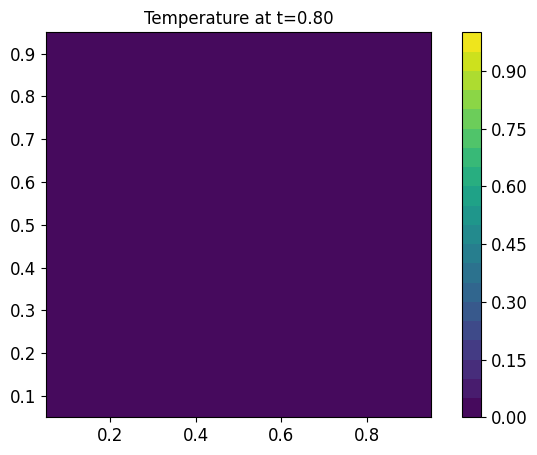

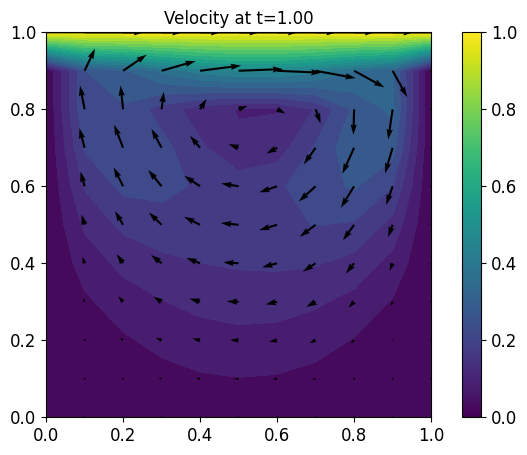

In [610]:
%matplotlib inline 

Ua = np.hstack( (uS,avg(np.vstack((uW,U,uE)),1),uN))
Va = np.vstack((vW,avg(np.hstack((vS,V,
                                  vN)),0),vE))
plt.figure()
plt.contourf(x,y,np.sqrt(Ua**2+Va**2).T,20)
plt.quiver(x,y,Ua.T,Va.T)
plt.gca().set_aspect(1.)
plt.colorbar()
plt.title(f'Velocity at t={k*dt:.2f}')
plt.show()

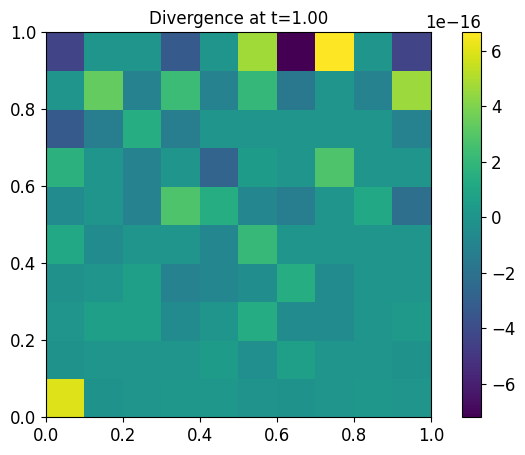

In [611]:
# compute divergence on cell centres
div = (np.diff( np.vstack( (uW,U, uE)),axis=0)/hx + np.diff( np.hstack(( vS, V, vN)),axis=1)/hy)
plt.figure()
plt.pcolor(avg(x),avg(y),div.T,shading='nearest')
plt.gca().set_aspect(1.)
plt.colorbar()
plt.title(f'Divergence at t={k*dt:.2f}')
plt.show()

## Analysis of the pressure Poisson equation:

Matrix structure:

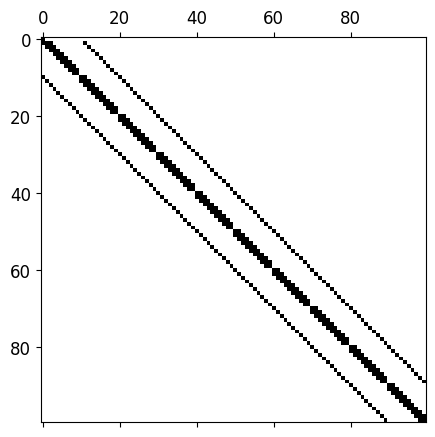

In [612]:
plt.figure()
plt.spy(Lp)
plt.show()

Size, rank and null space:

In [613]:
Lp.shape

(100, 100)

In [614]:
np.linalg.matrix_rank(Lp)

np.int64(100)

In [615]:
scl.null_space(Lp)

array([], shape=(100, 0), dtype=float64)